In [2]:
suppressPackageStartupMessages({
    source("~/public/SiyuanLuo/projects/benchmark/scripts/evaluation/lib_metrics.R")
    source("~/public/SiyuanLuo/projects/benchmark/scripts/clustering/lib_clustering.R")
    source("utils.R")
    library(ComplexHeatmap)
    library(circlize)
    library(ggrastr)
})

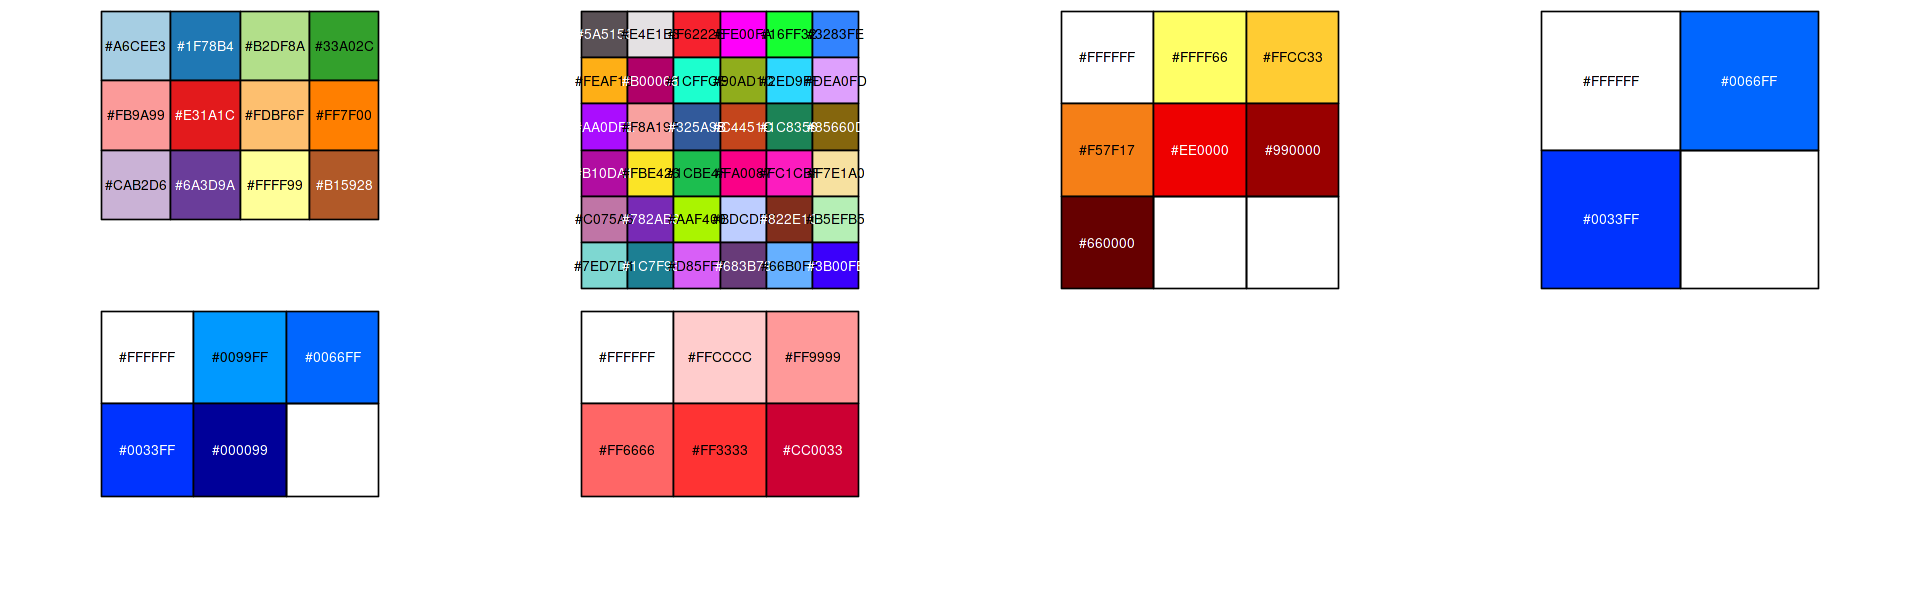

In [3]:
options(repr.plot.width=16, repr.plot.height=5)
par(mfrow=c(2,4))

show_col(my_col_m)
show_col(my_col_c)
show_col(my_color)
show_col(my_color_2)
show_col(my_color_3)
show_col(my_color_4)

In [4]:
dataset_ls <- c("Cell_line_mixing", "candidate1",  "candidate2", "Buenrostro_2018",  "Chen_2019",  "PBMC_multiomics") 
k_ls <- c(10, 13, 10, 9, 13, 15)

In [5]:
file1 <- "results_meta_data.tsv"
file2 <- "results_all_metrics.tsv"
df <- read.table(file1, sep='\t', header=TRUE)
df_metrics <- read.table(file2, sep='\t', header=TRUE)
df_metrics$dataset <- factor(df_metrics$dataset, levels = c("Cell line","Atlas1", "Atlas2","Buenrostro2018","Chen2019","10XPBMC"))
df_metrics$long_method <- factor(df_metrics$long_method, levels=c("aggregation", "SnapATAC", "ArchR_peaks", "ArchR_tiles","Signac_all_cell_peaks","Signac_by_cluster_peaks","SnapATAC2_cosine","SnapATAC2_jaccard"))

In [6]:
df_minimal <- df[!duplicated(df[c("scenario", "long_method")]), ]
dim(df_minimal)

[1] 48 19

In [7]:
root <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/"

In [7]:
# var_explained <- function(sobj, embedding_name="learned_embedding", n=10, trans=sqrt){
#     rd <- Reductions(sobj, embedding_name)
#     # compSD <- rd@stdev[1:n]  # change back when get new results
#     embed <- Embeddings(rd)[,1:n]
#     celltype <- sobj$ground_truth
#     counts <- sobj[[paste0("nCount_", "all_cell_peaks")]]
#     libsize <- counts$nCount_all_cell_peaks
#     ves <- apply(as.data.frame(embed), 2, celltype=celltype, libsize=libsize,  FUN=getVEdiff)
#     # return(sum(ves * compSD^2)/sum(compSD^2))
#     return(mean(ves))
# }

# #' Returns the increase in adjusted R^2 of models regressing an embedding vector
# #'   on celltype*sqrt(libsize) vs celltype only
# #'
# #' @param y The embedding vector
# #' @param celltype The celltype
# #' @param libsize The library size vector
# #' @param trans The transformation to apply to the library size (default sqrt)
# #'
# #' @return The difference in adj R^2
# getVEdiff <- function(y, celltype, libsize, trans=sqrt){
#   celltype <- as.factor(celltype)
#   libsize <- trans(libsize)
#   modfull <- summary(lm(y~celltype*libsize))
#   modreduced <- summary(lm(y~celltype))
#   max(0, modfull$adj.r.squared-modreduced$adj.r.squared)
# }

# Plot mean correlation 

In [8]:
cor_per_class <- function(embed, count_ls, label){
    df_cor <- data.frame(class=c(), cor=c(), dim=c())
    for(i in 1:dim(embed)[2]){
        data <- data.frame(x=embed[,i], y=count_ls, z=factor(label))
        a <- by(data, data$z, FUN = function(df) cor(df$x, df$y))
        cor_group <- as.data.frame(as.matrix(a))
        cor_group$class <- rownames(cor_group)
        cor_group$dim <- i
        colnames(cor_group) <- c( "cor","class","dim")
        df_cor <- rbind(df_cor, cor_group)
    }
    return(df_cor)
}

In [7]:
# n <- 5

# ds <- "PBMC_multiomics"

# df_ves <- data.frame(long_method=c(), variable=c(), value=c())
# df_r2 <- data.frame(sqrt_counts=c(), ground_truth=c(),variable=c(),value=c(),method=c(), long_method=c(), dataset=c())

# df <- df_minimal %>% filter(scenario==ds)
# for(i in 1:dim(df)[1]){
#     sobj <- readRDS(paste0(root, df$dataset2[i], "/", df$snn_file[i]))
#     embed <- Embeddings(Reductions(sobj, "learned_embedding"))
#     counts <- sobj[[paste0("nCount_", "all_cell_peaks")]]
#     ground_truth <- sobj$ground_truth

#     embed_sub <- embed[, 1:n]
#     colnames(embed_sub) <- paste0("Comp_", 1:n)
#     df_cor <- cor_per_class(embed_sub, counts$nCount_all_cell_peaks, ground_truth)

#     df_avg_cor <- aggregate(abs(cor) ~ dim, data = df_cor, FUN = mean)
#     colnames(df_avg_cor) <- c("dim","value")
#     df_ves <- rbind(df_ves, data.frame(long_method=df$long_method[i], variable=paste0("Comp_", 1:n), value=df_avg_cor$value))
#     df_scatter <- data.frame(embed_sub, sqrt_counts=sqrt(counts$nCount_all_cell_peaks), ground_truth=ground_truth)
#     df_long <- reshape2::melt(df_scatter, id.vars = c("sqrt_counts", "ground_truth"))
#     df_long$long_method <- df$long_method[i]
#     df_long$method <- df$method[i]
#     df_long$dataset_short <- df$dataset_short[i]
#     df_r2 <- rbind(df_r2, df_long)
# }
# saveRDS(list(df_r2=df_r2, ves=df_ves), file=paste0("Mean_abs_cor_" ,ds,".RDS"))


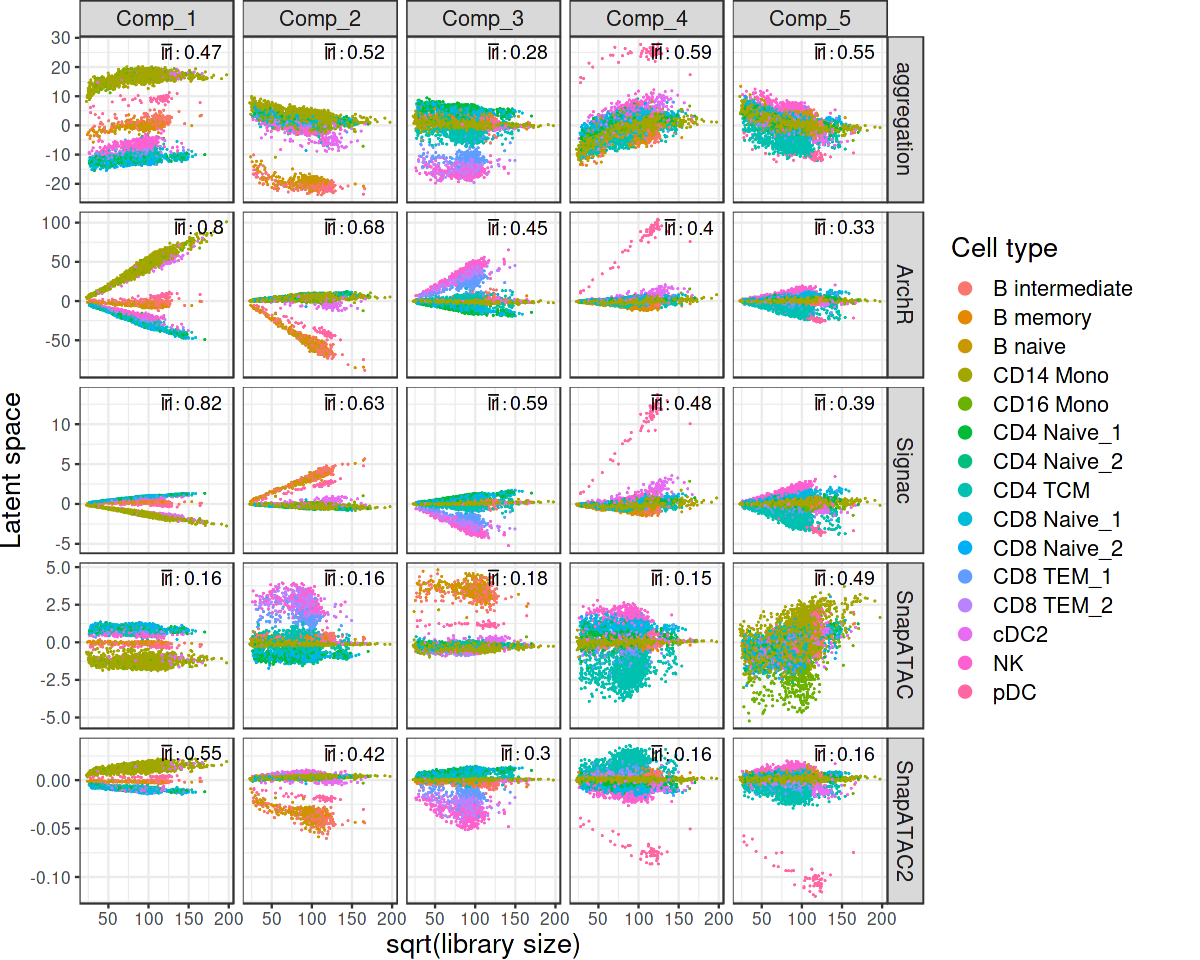

In [15]:
options(repr.plot.width=10, repr.plot.height=8)
ds <- "PBMC_multiomics"
ls <- readRDS(file=paste0("Mean_abs_cor_" ,ds,".RDS"))
ves <- ls[["ves"]]
df_r2 <- ls[["df_r2"]]


data_text <- ves
data_text$label <- paste0("bar(abs(r))", ": ", round(data_text$value, 2))
# data_text <- data.frame(r2=ves, label=paste0("\u0394","R^2", ": ", round(ves,2)), long_method=rep(unique(df_r2$long_method), each=n), variable=rep(unique(df_r2$variable), length(unique(df_r2$long_method))))
split_column <- strsplit(as.character(data_text$long_method), "_")
data_text$method<- sapply(split_column, `[`, 1)

df_r2 <- df_r2 %>% filter(long_method !="Signac_all_cell_peaks" & long_method !="ArchR_peaks" & long_method !="SnapATAC2_jaccard")
data_text <- data_text %>% filter(long_method !="Signac_all_cell_peaks" & long_method !="ArchR_peaks" & long_method !="SnapATAC2_jaccard")

p <- ggplot(df_r2, aes(x = sqrt_counts, y = value, color = ground_truth)) +
ggrastr::geom_point_rast(size=0.01) +
facet_grid(method ~ variable, scales = "free_y") + #, labeller = as_labeller(variable.labs, label_parsed)
scale_color_discrete(name = "Cell type") + 
labs(x="sqrt(library size)", y="Latent space", main=df_r2$dataset_short[1]) +
theme_bw() +
theme(text = element_text(size = 16), 
axis.text = element_text(size = 10),
plot.margin = unit(c(0,1.3,0,0), "cm")) + 
geom_text(
    data = data_text,
    mapping = aes(x=Inf, y=Inf, label=label),
    parse = TRUE, 
    size=4,
    hjust = 1.2,
    vjust = 1.5, 
    inherit.aes = FALSE
) + guides(colour = guide_legend(override.aes = list(size=3)))

p

In [17]:
pdf(paste0("lib_size_effect_cor_",ds, ".pdf"), width=10, height=8)
plot(p)
dev.off() 

png 
  2

# Plot a summary

In [7]:
# df_ves <- data.frame(long_method=c(), variable=c(), value=c(), dataset=c())

# for(ds in unique(df_minimal$scenario)){
# # for(ds in c("Cell_line_mixing")){
#     df <- df_minimal %>% filter(scenario==ds)
#     for(i in 1:dim(df)[1]){
#         res <- readRDS(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/library_size_effect/Mean_abs_cor_", ds, ".RDS"))
#         ves <- res[["ves"]]
#         ves$dataset <- ds
#         df_ves <- rbind(df_ves, ves)
#     }
# }

# mapping <- list("Cell_line_mixing" = "Cell line", 
#                      "candidate1" = "Atlas1", 
#                      "candidate2" = "Atlas2",
#                      "Buenrostro_2018" = "Buenrostro2018",
#                      "Chen_2019" = "Chen2019",
#                      "PBMC_multiomics" = "10XPBMC")

# df_ves <- df_ves %>% 
#   mutate(dataset_short = case_when(as.character(dataset) %in% names(mapping) ~ mapping[as.character(dataset)]))
# df_ves$dataset_short <- factor(df_ves$dataset_short, levels=c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC"))
# df_ves <- df_ves %>% group_by(long_method, dataset) %>% mutate(mean=mean(value))
# df_ves <- df_ves[!duplicated(df_ves[c("long_method", "dataset")]), ]

In [10]:
df_ves <- read.table("depth_correlation.tsv", sep='\t', header = TRUE)

In [11]:
df_wide <- as.data.frame(pivot_wider(df_ves[,c("long_method", "mean", "dataset_short")], names_from = dataset_short, values_from = mean))
df_wide$long_method <- df_wide$long_method
rownames(df_wide) <- df_wide$long_method
df_wide <- subset(df_wide, select=-long_method)

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


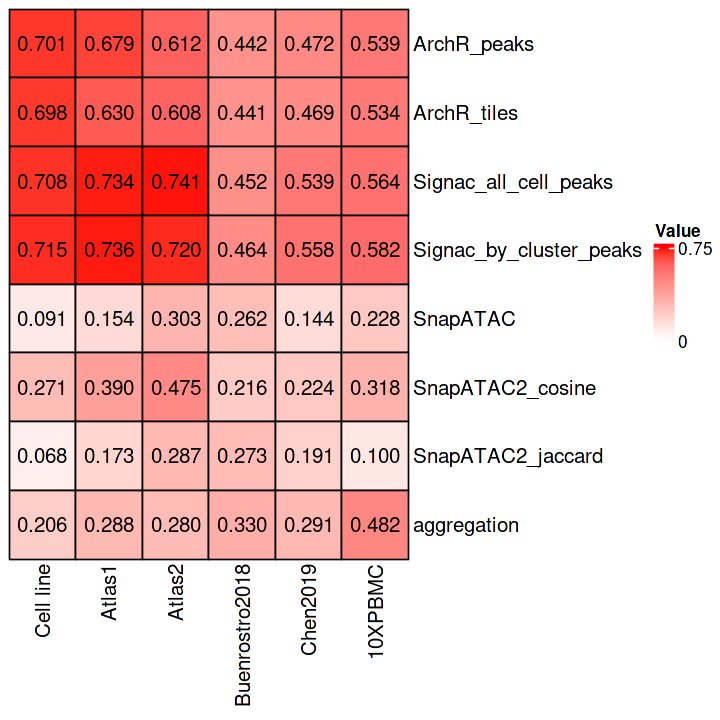

In [12]:
options(repr.plot.width=6, repr.plot.height=6)
maxv <- max(df_wide)
maxv <- 0.75
col_fun = colorRamp2(c(0, 0.8*maxv, maxv), c("white", "#FF6666", "red"))

p4 <- Heatmap(df_wide, 
name = "cv", 
col = col_fun, 
cluster_rows = FALSE, 
cluster_columns = FALSE, 
# column_title = "Average",
rect_gp = gpar(col = "black", lwd = 1), 
# bottom_annotation = column_ha, show_column_names = FALSE,
heatmap_legend_param = list(title = "Value", at=c(0, maxv)), 
# show_heatmap_legend = FALSE,
cell_fun = function(j, i, x, y, width, height, fill) {
    grid.text(sprintf("%.3f", df_wide[i, j]), x, y, gp = gpar(fontsize = 12))},
# column_order = c(6,2,3,4,1,5)
column_names_gp = grid::gpar(fontsize = 12),
  row_names_gp = grid::gpar(fontsize = 12),
column_order = c("Cell line", "Atlas1", "Atlas2", "Buenrostro2018", "Chen2019", "10XPBMC"),
row_order = c('ArchR_peaks','ArchR_tiles','Signac_all_cell_peaks','Signac_by_cluster_peaks','SnapATAC','SnapATAC2_cosine','SnapATAC2_jaccard','aggregation')
)

draw(p4)

In [13]:
pdf("Fig5b.pdf", width=6, height=6)
plot(p4)
dev.off() 

png 
  2

# Plot the Geary C index

In [44]:
df_g <- read.table("geary_c.tsv", sep='\t', header=TRUE)
df_long <- reshape2::melt(df_g, id.vars = c("long_method", "method","dataset"))
df_long$value <- -df_long$value
df_long$long_method <- factor(df_long$long_method, levels=c("aggregation","SnapATAC","ArchR_peaks","ArchR_tiles","Signac_all_cell_peaks","Signac_by_cluster_peaks","SnapATAC2_cosine","SnapATAC2_jaccard"))

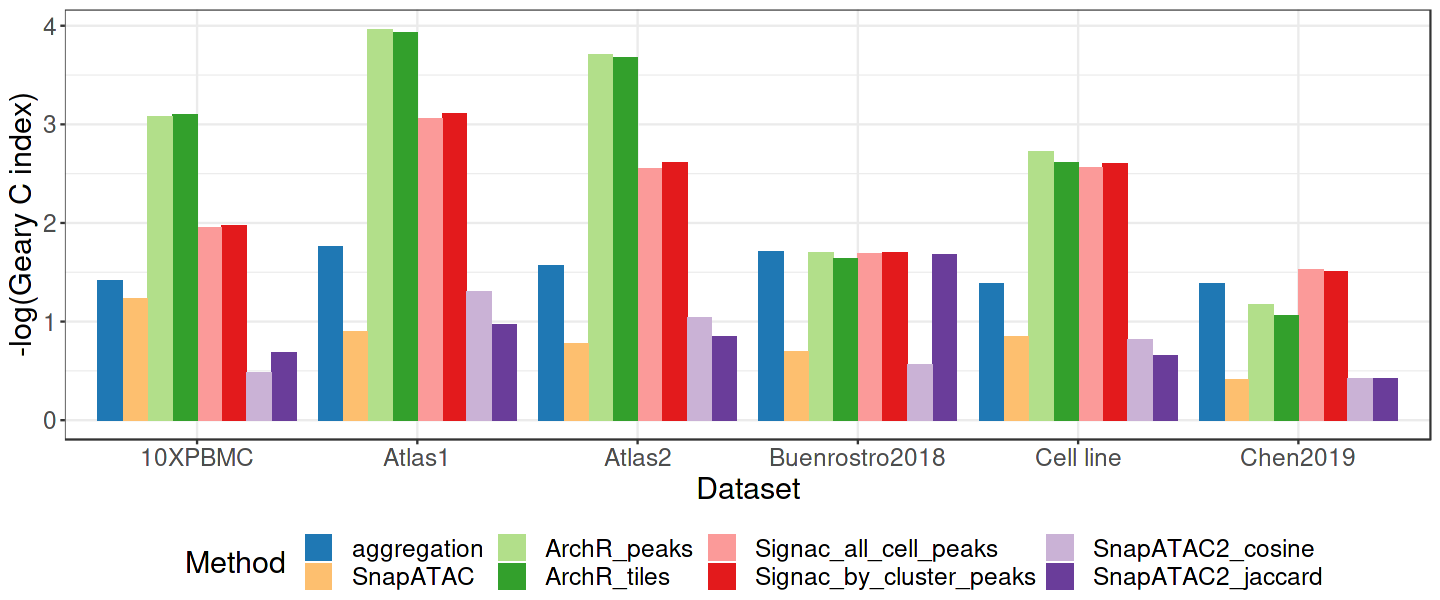

In [45]:
options(repr.plot.width=12, repr.plot.height=5)

  p <- df_long %>% filter(variable == "log_geary_c_knn") %>%
  ggplot(aes(x=dataset, y=value, fill=long_method)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Dataset", y = "-log(Geary C index)", fill = "Method") +
  scale_fill_manual(values = my_col_m3) +
  theme_bw() +
  theme(text = element_text(size = 18), plot.margin = unit(c(0.2,0.2,0,0.2), "cm"),
   legend.position = "bottom", 
              # legend.justification = c(1.2,0), 
              # legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt"),
              legend.spacing.x = unit(0.4, 'cm'))

  print(p)


In [28]:
pdf("Fig3_geary.c.pdf", width=12, height=5)
plot(p)
dev.off() 

png 
  2